##installing requiered packages


In [ ]:
!pip install rdkit-pypi
!pip install torch torchvision torchaudio
!pip install torch-geometric



##Preprocessing the dataset QM9



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
from torch_geometric.datasets import QM9
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/MyDatasets/QM9'
dataset = QM9(root=dataset_path)
data = dataset_path


Mounted at /content/drive


In [13]:
data = dataset
# Example: Accessing the first graph in the dataset
first_graph = dataset[0]
print(first_graph)


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


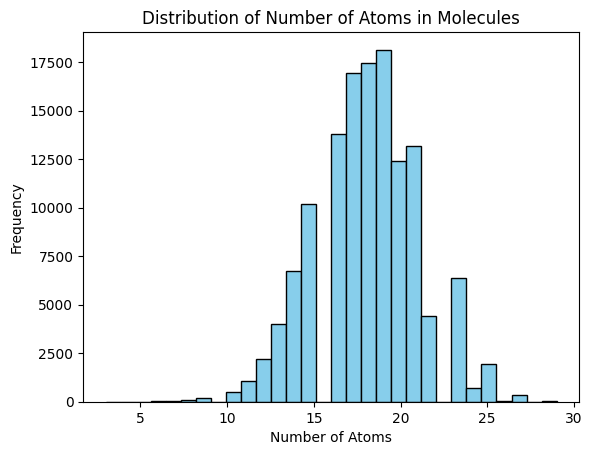

In [14]:
import matplotlib.pyplot as plt

num_atoms = [data.num_nodes for data in dataset]
plt.hist(num_atoms, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Atoms in Molecules')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.show()


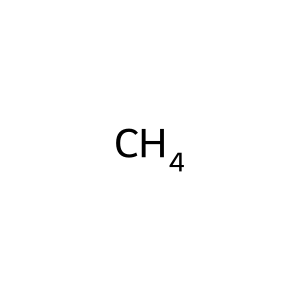

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert a data object to a molecule (ensure RDKit is installed)
data = dataset[0]  # Get the first molecule
smiles = data.smiles
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)


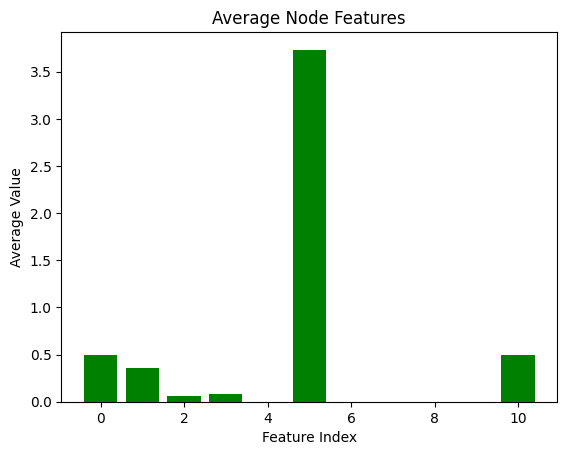

In [16]:
import numpy as np

avg_node_features = np.mean([np.mean(data.x.numpy(), axis=0) for data in dataset], axis=0)
plt.bar(range(len(avg_node_features)), avg_node_features, color='green')
plt.title('Average Node Features')
plt.xlabel('Feature Index')
plt.ylabel('Average Value')
plt.show()


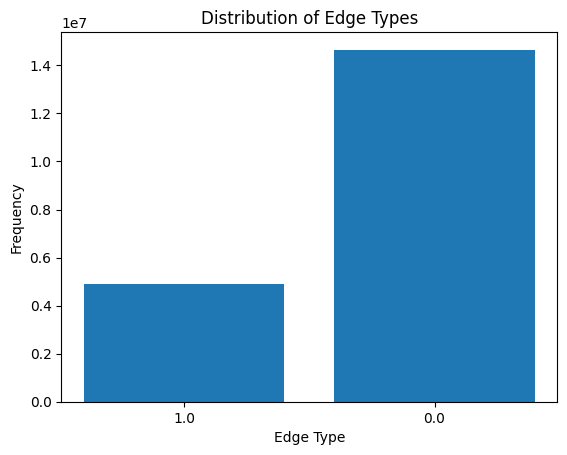

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Assuming each edge_attr tensor is 1D and represents a single edge type
edge_types = [e.item() for data in dataset for e in data.edge_attr.view(-1)]
edge_type_counts = Counter(edge_types)

# Prepare data for plotting
labels, values = zip(*edge_type_counts.items())
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.title('Distribution of Edge Types')
plt.xlabel('Edge Type')
plt.ylabel('Frequency')
plt.show()


## From SMILE to graph representation

In [70]:
def preprocess(data):

    node_features = data.x

    edge_features = data.edge_attr

    edge_index = data.edge_index


    return node_features, edge_features, edge_index





###split test and train

In [3]:
dataset = dataset.shuffle()

train_size = int(0.8 * len(dataset))  # 80%
test_size = len(dataset) - train_size  # 20%

train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]

In [5]:
processed_dataset = [preprocess(data) for data in dataset]

##define train and test Data loader

In [6]:
from torch_geometric.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
data = dataset[0]

node_feature_size = data.x.size(1)

print(f"The size of node features is: {node_feature_size}")


The size of node features is: 11


#convert labels to binary


In [ ]:
def convert_to_binary(label_tensor):
    # Convert all non-zero elements to 1, and zero elements to 0
    binary_tensor = (label_tensor > 0).int()
    return binary_tensor

# Apply this conversion to your dataset
for data in dataset:
    data.y = convert_to_binary(data.y)


##normalizing data

In [ ]:
for data in train_loader:
    # Normalize the target data to be in the range [0, 1]
    data.y = (data.y > 0).float()


#setting the encoder and decoder input output dimensions


In [9]:
input_dim = data.x.size(1)
hidden_dim = 64
latent_dim = 32
output_dim = 19


In [10]:
import torch
import torch.nn as nn
from torch_geometric.nn import global_mean_pool


class GraphVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(GraphVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        mu, logvar = self.encoder(x, edge_index)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z, edge_index, batch)

        return recon, mu, logvar



In [11]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GCNEncoder, self).__init__()
        self.gc1 = GCNConv(input_dim, hidden_dim)
        # Separate GCN layers for mu and logvar
        self.gc2_mu = GCNConv(hidden_dim, latent_dim)
        self.gc2_logvar = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        mu = self.gc2_mu(x, edge_index)
        logvar = self.gc2_logvar(x, edge_index)
        return mu, logvar


class GCNDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim=19):
        super(GCNDecoder, self).__init__()
        self.gc1 = GCNConv(latent_dim, hidden_dim)
        self.gc2 = GCNConv(hidden_dim, output_dim)

    def forward(self, z, edge_index, batch):
        z = F.relu(self.gc1(z, edge_index))
        z = self.gc2(z, edge_index)
        z = global_mean_pool(z, batch)
        return torch.sigmoid(z)



gcn_vae = GraphVAE(GCNEncoder(input_dim, hidden_dim, latent_dim), GCNDecoder(latent_dim, hidden_dim, output_dim))


In [12]:
def vae_loss(reconstructed, original, mu, logvar):
    recon_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div



In [53]:
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    total_kl_div = 0

    for data in train_loader:
        optimizer.zero_grad()


        reconstructed, mu, logvar = model(data)


        targets = (data.y > 0).float()


        recon_loss = F.binary_cross_entropy(reconstructed, targets, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


        loss = recon_loss + kl_div
        total_loss += loss.item()
        total_kl_div += kl_div.item()


        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader.dataset)
    average_kl_div = total_kl_div / len(train_loader.dataset)
    return average_loss, average_kl_div



In [15]:
import torch.optim as optim
learning_rate = 0.001


optimizer = optim.Adam(gcn_vae.parameters(), lr=learning_rate)
num_epochs=20


train_losses = []
kl_divergences = []
for epoch in range(num_epochs):
    train_loss, kl_div = train(gcn_vae, train_loader, optimizer)
    train_losses.append(train_loss)
    kl_divergences.append(kl_div)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, KL Divergence: {kl_div:.4f}')


Epoch 1/20, Train Loss: 1.4184, KL Divergence: 0.4613
Epoch 2/20, Train Loss: 0.6814, KL Divergence: 0.0004
Epoch 3/20, Train Loss: 0.6805, KL Divergence: 0.0005
Epoch 4/20, Train Loss: 0.6801, KL Divergence: 0.0005
Epoch 5/20, Train Loss: 0.6795, KL Divergence: 0.0004
Epoch 6/20, Train Loss: 0.6792, KL Divergence: 0.0004
Epoch 7/20, Train Loss: 0.6788, KL Divergence: 0.0004
Epoch 8/20, Train Loss: 0.6784, KL Divergence: 0.0004
Epoch 9/20, Train Loss: 0.6782, KL Divergence: 0.0003
Epoch 10/20, Train Loss: 0.6780, KL Divergence: 0.0003
Epoch 11/20, Train Loss: 0.6778, KL Divergence: 0.0003
Epoch 12/20, Train Loss: 0.6779, KL Divergence: 0.0003
Epoch 13/20, Train Loss: 0.6773, KL Divergence: 0.0003
Epoch 14/20, Train Loss: 0.6774, KL Divergence: 0.0003
Epoch 15/20, Train Loss: 0.6772, KL Divergence: 0.0003
Epoch 16/20, Train Loss: 0.6770, KL Divergence: 0.0003
Epoch 17/20, Train Loss: 0.6770, KL Divergence: 0.0003
Epoch 18/20, Train Loss: 0.6766, KL Divergence: 0.0003
Epoch 19/20, Train 

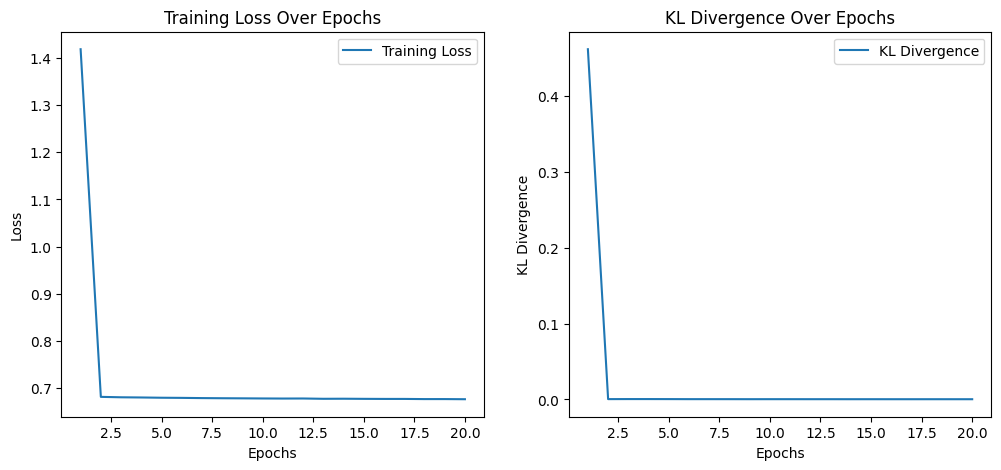

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting KL divergence
plt.subplot(1, 2, 2)
plt.plot(epochs, kl_divergences, label='KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence Over Epochs')
plt.legend()

plt.show()


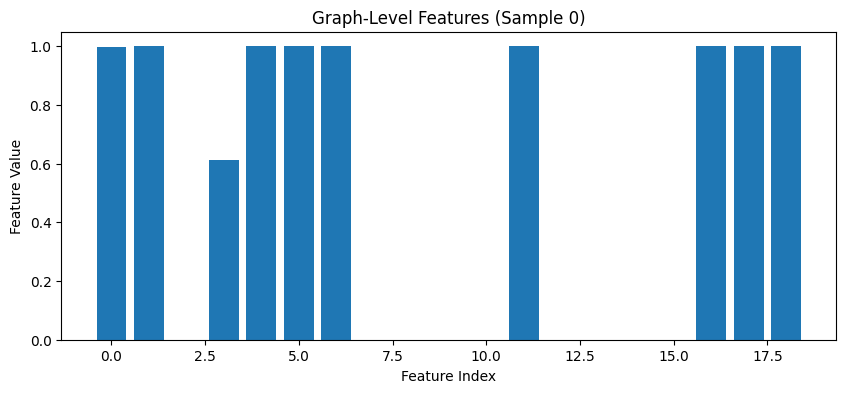

In [27]:
import matplotlib.pyplot as plt

# Assuming you have the decoder output as sample_adj
plt.figure(figsize=(10, 4))
plt.bar(range(len(sample_adj)), sample_adj)
plt.title(f'Graph-Level Features (Sample {sample_index})')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()



In [60]:
from torch_geometric.nn import GATConv



class GATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GATEncoder, self).__init__()
        self.gat1 = GCNConv(input_dim, hidden_dim)
        # Separate GCN layers for mu and logvar
        self.gat2_mu = GCNConv(hidden_dim, latent_dim)
        self.gat2_logvar = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))
        mu = self.gat2_mu(x, edge_index)
        logvar = self.gat2_logvar(x, edge_index)
        return mu, logvar


class GATDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(GATDecoder, self).__init__()
        self.gat1 = GATConv(latent_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, output_dim)

    def forward(self, z, edge_index, batch):
        z = F.relu(self.gat1(z, edge_index))
        z = self.gat2(z, edge_index)
        z = global_mean_pool(z, batch)
        return torch.sigmoid(z)

gat_vae = GraphVAE(GATEncoder(input_dim, hidden_dim, latent_dim), GATDecoder(latent_dim, hidden_dim, output_dim))


In [58]:
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn.functional as F
import torch
import torch.nn as nn

class GATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GATEncoder, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2_mu = GATConv(hidden_dim, latent_dim)
        self.gat2_logvar = GATConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))
        mu = self.gat2_mu(x, edge_index)
        logvar = self.gat2_logvar(x, edge_index)
        return mu, logvar


class GATDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(GATDecoder, self).__init__()
        self.gat1 = GATConv(latent_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        z = F.relu(self.gat1(z, edge_index))
        z = self.gat2(z, edge_index)

        return torch.sigmoid(z)

gat_vae = GraphVAE(GATEncoder(input_dim, hidden_dim, latent_dim), GATDecoder(latent_dim, hidden_dim, output_dim))


In [64]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    total_kl_div = 0

    for data in train_loader:
        optimizer.zero_grad()


        mu, logvar = model.encoder(data.x, data.edge_index)
        z = model.reparameterize(mu, logvar)


        reconstructed = model.decoder(z, data.edge_index, data.batch)

        data.y = data.y.float()
        data.y = (data.y > 0).float()


        recon_loss = F.binary_cross_entropy(reconstructed, data.y.view(-1, reconstructed.size(1)), reduction='sum')



        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


        loss = recon_loss + kl_div

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kl_div += kl_div.item()

    average_loss = total_loss / len(train_loader.dataset)
    average_kl_div = total_kl_div / len(train_loader.dataset)
    return average_loss, average_kl_div

optimizer = optim.Adam(gat_vae.parameters(), lr=0.001)


num_epochs = 20
train_losses = []
kl_divergences = []
for epoch in range(num_epochs):
    train_loss, kl_div = train(gat_vae, train_loader, optimizer)
    train_losses.append(train_loss)
    kl_divergences.append(kl_div)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, KL Divergence: {kl_div:.4f}')


Epoch 1/20, Train Loss: 1.5579, KL Divergence: 0.6775
Epoch 2/20, Train Loss: 0.6831, KL Divergence: 0.0007
Epoch 3/20, Train Loss: 0.6820, KL Divergence: 0.0006
Epoch 4/20, Train Loss: 0.6815, KL Divergence: 0.0006
Epoch 5/20, Train Loss: 0.6802, KL Divergence: 0.0005
Epoch 6/20, Train Loss: 0.6799, KL Divergence: 0.0005
Epoch 7/20, Train Loss: 0.6791, KL Divergence: 0.0005
Epoch 8/20, Train Loss: 0.6790, KL Divergence: 0.0004
Epoch 9/20, Train Loss: 0.6788, KL Divergence: 0.0004
Epoch 10/20, Train Loss: 0.6787, KL Divergence: 0.0004
Epoch 11/20, Train Loss: 0.6779, KL Divergence: 0.0004
Epoch 12/20, Train Loss: 0.6779, KL Divergence: 0.0004
Epoch 13/20, Train Loss: 0.6768, KL Divergence: 0.0004
Epoch 14/20, Train Loss: 0.6728, KL Divergence: 0.0007
Epoch 15/20, Train Loss: 0.6686, KL Divergence: 0.0009
Epoch 16/20, Train Loss: 0.6669, KL Divergence: 0.0011
Epoch 17/20, Train Loss: 0.6656, KL Divergence: 0.0011
Epoch 18/20, Train Loss: 0.6648, KL Divergence: 0.0011
Epoch 19/20, Train 

Epoch 1/20, Train Loss: 0.6622, KL Divergence: 0.0004
Epoch 2/20, Train Loss: 0.6606, KL Divergence: 0.0004
Epoch 3/20, Train Loss: 0.6622, KL Divergence: 0.0004
Epoch 4/20, Train Loss: 0.6615, KL Divergence: 0.0004
Epoch 5/20, Train Loss: 0.6610, KL Divergence: 0.0004
Epoch 6/20, Train Loss: 0.6624, KL Divergence: 0.0004
Epoch 7/20, Train Loss: 0.6624, KL Divergence: 0.0004
Epoch 8/20, Train Loss: 0.6609, KL Divergence: 0.0004
Epoch 9/20, Train Loss: 0.6621, KL Divergence: 0.0004
Epoch 10/20, Train Loss: 0.6613, KL Divergence: 0.0004
Epoch 11/20, Train Loss: 0.6621, KL Divergence: 0.0004
Epoch 12/20, Train Loss: 0.6621, KL Divergence: 0.0004
Epoch 13/20, Train Loss: 0.6617, KL Divergence: 0.0004
Epoch 14/20, Train Loss: 0.6628, KL Divergence: 0.0004
Epoch 15/20, Train Loss: 0.6612, KL Divergence: 0.0004
Epoch 16/20, Train Loss: 0.6623, KL Divergence: 0.0004
Epoch 17/20, Train Loss: 0.6617, KL Divergence: 0.0004
Epoch 18/20, Train Loss: 0.6622, KL Divergence: 0.0004
Epoch 19/20, Train 

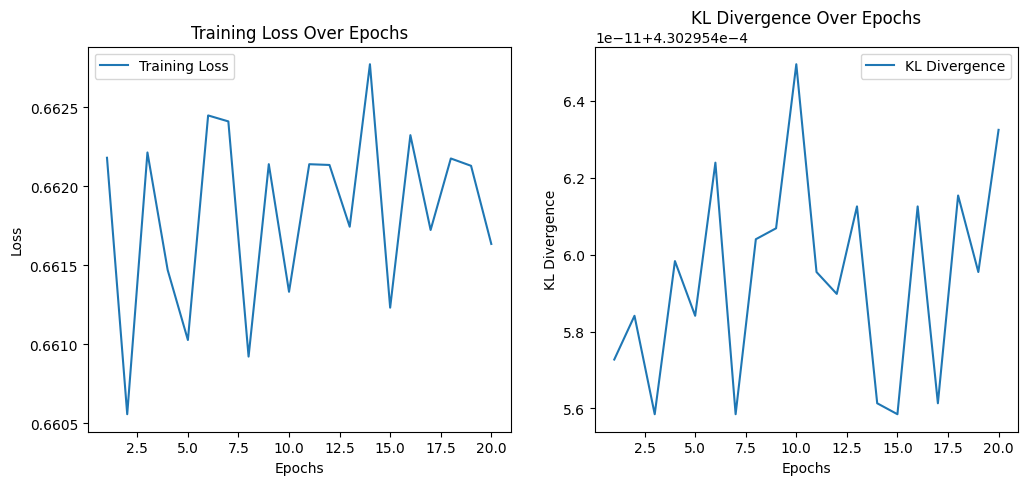

In [69]:
import torch.optim as optim
learning_rate = 0.001

# Initialize the optimizer
optimizer = optim.Adam(gcn_vae.parameters(), lr=learning_rate)
num_epochs=20

# Training loop
train_losses = []
kl_divergences = []
for epoch in range(num_epochs):
    train_loss, kl_div = train(gat_vae, train_loader, optimizer)
    train_losses.append(train_loss)
    kl_divergences.append(kl_div)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, KL Divergence: {kl_div:.4f}')

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plotting KL divergence
plt.subplot(1, 2, 2)
plt.plot(epochs, kl_divergences, label='KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence Over Epochs')
plt.legend()

plt.show()